# ConvexNet v2版本：为了满足先验的凸性假设，需要保证核函数网络的所有权重W都大于0，之前使用将权重平方的方式保证大于0，现在改为把输入特征的网络的激活函数设为softplus函数，以保证输出结果W都大于0

# 该版本的改进是用实际业务数据进行训练后发现T和Y的关系具有城市异质性，不足是额外限制了所有偏置B大于0，且所有权重W和所有偏置B共用一个输入特征的网络。

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.utils.data as data
import matplotlib.pyplot as plt
import pandas as pd
from time import sleep
from tqdm import tqdm

# 模型注意事项：
# 1. 实例化网络时需要输入T（treatment样本）、X（feature样本）和Y（output样本），原因是网络需要寻找合适的初始化参数，有利于训练时网络的收敛。
# 2. 参数kernel_num可以输入整数，如100，也可以输入元组/列表，如(50, 100, 200)。前者表示核函数层只有1层，每层有100个节点，后者表示核函数层有3层，第一层50个节点，第二层100个节点，第三层200个节点。（核函数层的具体定义和构造方法请查阅说明文档）
# 3. 参数hidden_num可以输入整数，如100，也可以输入元组/列表，如(50, 100, 200)。前者表示输入X的网络只有1层隐藏层，每层有100个节点，后者表示输入X的网络有3层隐藏层，第一层50个节点，第二层100个节点，第三层200个节点。（隐藏层都是线性全连接层）

In [3]:
class HiddenNet(nn.Module):


    def __init__(self, X, w_target, b_target, hidden_num):
        super(HiddenNet, self).__init__()
        
        self.hidden_num = hidden_num
        self.w_shape = w_target.shape
        self.w_layer = list()
        self.b_layer = list()
        self.w_bias = list()
        self.w_scale = list()
        self.b_bias = list()
        self.b_scale = list()

        stream = X
        for i, l in enumerate(hidden_num):
            self.w_layer.append(nn.Linear(stream.shape[1], l).cuda())
            self.register_parameter(f'WL{i}P0', list(self.w_layer[i].parameters())[0])
            self.register_parameter(f'WL{i}P1', list(self.w_layer[i].parameters())[1])
            stream = F.softplus(self.w_layer[i](stream))
            self.w_bias.append(stream.mean(axis=0))
            self.w_scale.append(stream.std(axis=0))
            stream = (stream - self.w_bias[i])/self.w_scale[i]
        
        self.w_layer.append(nn.Linear(l, w_target.shape[0]*w_target.shape[1]).cuda())
        self.register_parameter(f'WL{i + 1}P0', list(self.w_layer[i + 1].parameters())[0])
        self.register_parameter(f'WL{i + 1}P1', list(self.w_layer[i + 1].parameters())[1])
        stream = F.softplus(self.w_layer[i + 1](stream))
        self.w_bias.append(torch.zeros(w_target.shape[0]*w_target.shape[1]).cuda())
        self.w_scale.append((stream.max(axis=0)[0] - stream.min(axis=0)[0])/(4*w_target.flatten()))
        stream = (stream - self.w_bias[i + 1])/self.w_scale[i + 1]
        W = stream.reshape((-1, self.w_shape[0], self.w_shape[1]))

        stream = X
        for i, l in enumerate(self.hidden_num):
            self.b_layer.append(nn.Linear(stream.shape[1], l).cuda())
            self.register_parameter(f'BL{i}P0', list(self.b_layer[i].parameters())[0])
            self.register_parameter(f'BL{i}P1', list(self.b_layer[i].parameters())[1])
            stream = torch.tanh(self.b_layer[i](stream))
            self.b_bias.append(stream.mean(axis=0))
            self.b_scale.append(stream.std(axis=0))
            stream = (stream - self.b_bias[i])/self.b_scale[i]
            
        self.b_layer.append(nn.Linear(l, b_target.shape[0]).cuda())
        self.register_parameter(f'BL{i + 1}P0', list(self.b_layer[i + 1].parameters())[0])
        self.register_parameter(f'BL{i + 1}P1', list(self.b_layer[i + 1].parameters())[1])
        stream = self.b_layer[i + 1](stream)
        self.b_bias.append(stream.mean(axis=0) - stream.std(axis=0)*b_target)
        self.b_scale.append(stream.std(axis=0))
        B = (stream - self.b_bias[i + 1])/self.b_scale[i + 1]


    def forward(self, X):

        stream = X
        for i in range(len(self.hidden_num) + 1):
            stream = F.softplus(self.w_layer[i](stream))
            stream = (stream - self.w_bias[i])/self.w_scale[i]
        W = stream.reshape((-1, self.w_shape[0], self.w_shape[1]))
        
        stream = X
        for i in range(len(self.hidden_num)):
            stream = torch.tanh(self.b_layer[i](stream))
            stream = (stream - self.b_bias[i])/self.b_scale[i]
        stream = self.b_layer[i + 1](stream)
        B = (stream - self.b_bias[i + 1])/self.b_scale[i + 1]

        return W, B

In [4]:
class ConvexNet(nn.Module):


    def __init__(self, T, X, Y, kernel_num, hidden_num):
        super(ConvexNet, self).__init__()

        if isinstance(kernel_num, int):
            kernel_num = tuple([kernel_num])
        if isinstance(hidden_num, int):
            hidden_num = tuple([hidden_num])

        self.kernel_num = kernel_num
        self.hidden_net = list()
        self.bias = list()
        self.scale = list()

        stream = T
        for i, k in enumerate(kernel_num):
            linear_layer = nn.Linear(stream.shape[1], k).cuda()
            w = torch.abs(linear_layer.weight)
            b = linear_layer.bias
            self.hidden_net.append(HiddenNet(X, w, b, hidden_num).cuda())
            for p, parameter in enumerate(self.hidden_net[i].parameters()):
                self.register_parameter(f'H{i}P{p}', parameter)
            W, B = self.hidden_net[i](X)
            stream = self.kernel(torch.bmm(stream.unsqueeze(1), W.transpose(1, 2)).squeeze(1) + B)
            self.bias.append(stream.mean(axis=0))
            self.scale.append(stream.std(axis=0))
            stream = (stream - self.bias[i])/self.scale[i]
        
        linear_layer = nn.Linear(k, Y.shape[1]).cuda()
        w = torch.abs(linear_layer.weight)
        b = linear_layer.bias
        self.hidden_net.append(HiddenNet(X, w, b, hidden_num).cuda())
        for p, parameter in enumerate(self.hidden_net[i + 1].parameters()):
            self.register_parameter(f'H{i + 1}P{p}', parameter)
        W, B = self.hidden_net[i + 1](X)
        stream = torch.bmm(stream.unsqueeze(1), W.transpose(1, 2)).squeeze(1) + B
        self.bias.append(stream.mean(axis=0) - Y.mean(axis=0)*stream.std(axis=0)/Y.std(axis=0))
        self.scale.append(stream.std(axis=0)/Y.std(axis=0))
        output = (stream - self.bias[i + 1])/self.scale[i + 1]


    def forward(self, T, X):
        
        stream = T
        for i in range(len(self.kernel_num)):
            W, B = self.hidden_net[i](X)
            stream = self.kernel(torch.bmm(stream.unsqueeze(1), W.transpose(1, 2)).squeeze(1) + B)
            stream = (stream - self.bias[i])/self.scale[i]
        
        W, B = self.hidden_net[i + 1](X)
        stream = torch.bmm(stream.unsqueeze(1), W.transpose(1, 2)).squeeze(1) + B
        output = (stream - self.bias[i + 1])/self.scale[i + 1]

        return output


    def kernel(self, input):
        
        output = torch.zeros_like(input).cuda()
        ix1 = int(input.shape[1]/4)
        ix2 = 2*ix1
        ix3 = int((input.shape[1] - ix2)/2) + ix2

        output[:, :ix1] = input[:, :ix1] - torch.log(torch.exp(input[:, :ix1]) + 1)
        
        output[:, ix1:ix2][input[:, ix1:ix2] >= 0] = torch.log(input[:, ix1:ix2][input[:, ix1:ix2] >= 0] + 1)
        output[:, ix1:ix2][input[:, ix1:ix2] < 0] = torch.log(1 - input[:, ix1:ix2][input[:, ix1:ix2] < 0]) + 2*input[:, ix1:ix2][input[:, ix1:ix2] < 0]
       
        a1 = torch.linspace(0, 1, ix3 - ix2 + 1)[1:].repeat((input.shape[0], 1)).cuda()
        pos1 = (input[:, ix2:ix3] >= 0)
        neg1 = (input[:, ix2:ix3] < 0)
        output[:, ix2:ix3][pos1] = (input[:, ix2:ix3][pos1] + 1)**a1[pos1] - 1
        output[:, ix2:ix3][neg1] = (1 - input[:, ix2:ix3][neg1])**a1[neg1] + 2*a1[neg1]*input[:, ix2:ix3][neg1] - 1
       
        a2 = torch.linspace(0, 1, input.shape[1] - ix3 + 1)[1:].repeat((input.shape[0], 1)).cuda()
        pos2 = (input[:, ix3:] >= 0)
        neg2 = (input[:, ix3:] < 0)
        output[:, ix3:][pos2] = -1/((input[:, ix3:][pos2] + 1)**a2[pos2]) + 1
        output[:, ix3:][neg2] = -1/((1 - input[:, ix3:][neg2])**a2[neg2]) + 2*a2[neg2]*input[:, ix3:][neg2] + 1
      
        return output        

In [5]:
df = pd.read_csv('feature_new.csv')

drop_columns = ['dt', 'group_type_exp', 'group_type_blank', 'sample_size_blank', 'sample_size_exp', 
                'snpc_fkdp_subsidy_hufan_ratio_3d', 'snpc_fkdp_subsidy_hufan_ratio_14d_term']
T_columns = ['pk_hufan_rate_exp', 'th_hufan_rate_exp', 'fk_hufan_rate_exp', 
             'fk_subsidy_exp', 'fk_subsidy_exp.1',
             'pk_hufan_rate_blank', 'th_hufan_rate_blank', 'fk_hufan_rate_blank', 
             'delta_pk_rate', 'delta_th_rate', 'delta_hufan_rate', 
             'kh_sub_rate',
             'pk_target_c_rate', 'th_target_c_rate', 'fk_target_rate'] # 有缺失值
Y_columns = ['wyc_gmv', 'kuaiche_gmv', 'tehui_gmv', 'fk_gmv',
             'pk_gmv_exp', 'th_gmv_exp', 'fk_gmv_exp', 'wc_gmv_exp', 'wyc_gmv_exp', 'wc_gmv_exp.1', 'wyc_gmv_exp.1',
             'pk_gmv_blank', 'th_gmv_blank', 'fk_gmv_blank', 
             'dgmv_ratio_pk', 'dgmv_ratio_th', 'dgmv_ratio', 
             'real_roi']
feature_columns = list(set(df.columns) - set(drop_columns + T_columns + Y_columns))

T = torch.from_numpy(df['delta_hufan_rate'].values).reshape(-1, 1).float()
X = torch.from_numpy(df[feature_columns].values).float()
Y = torch.from_numpy(df['dgmv_ratio'].values).reshape(-1, 1).float()

city = 27
T = torch.from_numpy(df[df['city_id'] <= city]['delta_hufan_rate'].values).reshape(-1, 1).float().cuda()
X = torch.from_numpy(df[df['city_id'] <= city][feature_columns].values).float().cuda()
Y = torch.from_numpy(df[df['city_id'] <= city]['dgmv_ratio'].values).reshape(-1, 1).float().cuda()

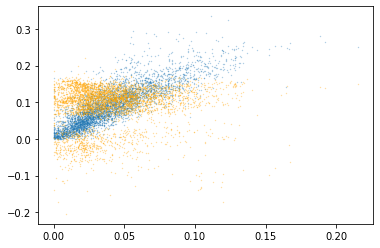

In [6]:
CN = ConvexNet(T, X, Y, kernel_num=100, hidden_num=100).cuda()
Y_pred = CN(T, X)
plt.scatter(T.cpu(), Y.cpu(), s=0.1, alpha=0.5)
plt.scatter(T.cpu().detach().numpy(), Y_pred.cpu().detach().numpy(), color='orange', s=0.1, alpha=0.5)

In [7]:
TX = torch.cat((T, X), axis=1)
loader = data.DataLoader(dataset=data.TensorDataset(TX, Y), batch_size=16, shuffle=True)

loss_fn = nn.MSELoss().cuda()
optimizer = torch.optim.ASGD(list(CN.parameters()), lr=1e-3)

CN.train()
for epoch in range(10000):
    with tqdm(loader, unit="batch") as tepoch:
        for batch_tx, batch_y in tepoch:
            tepoch.set_description(f"Epoch {epoch}")
            batch_t = batch_tx[:, 0].reshape(-1, 1)
            batch_x = batch_tx[:, 1:]
            y_pred = CN(batch_t, batch_x)
            loss = loss_fn(y_pred, batch_y)
            optimizer.zero_grad()
            loss.backward(retain_graph=True)
            optimizer.step()
            r2 = 1 - loss.item()/batch_y.var()
            tepoch.set_postfix(MSE=loss.item(), R2=r2.item())
            sleep(0.0001)
    period = 1
    if (epoch + 1) % period == 0:
        plt.figure(num=int((epoch + 1)/period))
        Y_pred = CN(T, X)
        plt.scatter(T, Y, s=0.1, alpha=0.5)
        plt.scatter(T.detach().numpy(), Y_pred.detach().numpy(), color='orange', s=0.1, alpha=0.5)
        loss = loss_fn(Y_pred, Y)
        r2 = 1 - loss.item()/Y.var()
        plt.title('$Epoch %d: MSE=%.3g, R^2=%.3g$' % (epoch + 1, loss, r2))
        plt.show()

Epoch 0:   0%|          | 0/261 [00:00<?, ?batch/s, MSE=0.00717, R2=-1.02]


RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.cuda.FloatTensor [100, 1]], which is output 0 of AsStridedBackward0, is at version 3; expected version 1 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).